# Image Datasets

> Image datasets

In [ ]:
#| default_exp image.datasets

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export

# torch
import torch
import torch.nn as nn
from torch import Tensor # type hint
import torch.utils.data as data
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
import torch.nn.functional as F
import torchvision.transforms.functional as TF
# torchvision
from torchvision.transforms import v2 as transforms, Compose
import torchvision
# lightning
from lightning import LightningDataModule

# hugging face
from datasets import load_dataset, load_dataset_builder, load_from_disk
from datasets import GeneratorBasedBuilder, DatasetInfo, Features, ClassLabel, Image, Value, SplitInfo
from datasets.info import DatasetInfo
from datasets.splits import NamedSplit, SplitDict

# math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
import PIL

# python libs
import os
import logging
import warnings
from pprint import pprint
from plum import dispatch
from rich import print
from functools import partial

# configs
from omegaconf import OmegaConf
from hydra.utils import instantiate
# typing
from typing import Optional, Tuple, List, Callable, Union, Dict

# nimrod
from nimrod.data.core import DataModule
from nimrod.utils import set_seed


set_seed(42)
logger = logging.getLogger(__name__)
# logger.setLevel(logging.DEBUG)
plt.set_loglevel('INFO')
logging.getLogger('matplotlib.image').setLevel(logging.ERROR)

Seed set to 42


## Plots

In [ ]:
#| export

def show_images(x:torch.Tensor, ncols:int=8):
    """Given a batch of images x, make a grid and convert to PIL"""
    # x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=ncols, normalize=False)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

## ImageDataset Mixin

In [ ]:
#| export
class ImagePlotMixin:
    " Mixin class for image datasets providing visualization of (image, label) samples"

    @staticmethod
    def plot(
        ds: Dataset,
        idx: int,
        int2label: Dict[int, str] | Callable = None,

        ):
        X, label = ds[idx]
        C, H, W = X.shape

        fig, axs = plt.subplots(figsize=(2, 2))
        
        if C == 1:
            # X (1, H, W)
            plt.imshow(X[0].numpy(), cmap='gray')
            # warnings.filterwarnings("ignore")
        elif C == 3:
            # X (3, H, W)
            plt.imshow(X.numpy().transpose(1,2,0).reshape(H,W,C))
            # warnings.filterwarnings("ignore")
        # Convert label to string if possible
        try:
            # label_str = ds.hf_ds.features['label'].int2str(label)
            if isinstance(int2label, dict):
                label_str = int2label[label]
            elif isinstance(int2label, Callable):
                label_str = int2label(label)
            else:
                label_str = str(label)
        except AttributeError:  
            logger.warning("Unable to convert label to string")
        plt.title(f"Label: {label_str}")
        
        plt.show()

    @staticmethod
    def plot_grid(
        ds: Dataset,
        n_rows:int=3,
        n_cols:int=3,
        int2label: Dict[int, str] | Callable = None
        ):
        """
        Plot a grid of random images from the dataset
        
        Args:
            n_rows (int): Number of rows in the grid
            n_cols (int): Number of columns in the grid
        """
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
        
        # Flatten axs if it's a 2D array
        if n_rows > 1 and n_cols > 1:
            axs = axs.flatten()
        
        for i in range(n_rows * n_cols):
            # Randomly select an index
            idx = torch.randint(0, len(ds), (1,)).item()
            
            # Get image and label
            img, label = ds[idx]
            C, H, W = img.shape
            
            # Handle different channel configurations
            if C == 1:  # Grayscale
                plot_img = img[0].numpy()
                cmap = 'gray'
            elif C == 3:  # RGB
                plot_img = img.numpy().transpose(1, 2, 0).reshape(H,W,C)
                cmap = None
            
            # Plot the image
            axs[i].imshow(plot_img, cmap=cmap) #.astype(np.uint8)
            # warnings.filterwarnings("ignore")
            
            # Convert label to string if possible
            try:
                # label_str = ds.hf_ds.features['label'].int2str(label)
                max_length_label = 20 # max length of the label string
                if isinstance(int2label, dict):
                    label_str = int2label[label][0:max_length_label]
                elif isinstance(int2label, Callable):
                    label_str = int2label(label)[0:max_length_label]
                else:
                    label_str = str(label)[0:max_length_label]
            except AttributeError:
                logger.warning("Unable to convert label to string")
            
            axs[i].set_title(f"{label_str}")
            axs[i].axis('off')
    
        plt.tight_layout()
        plt.show()

In [ ]:
# ImagePlotMixin.plot(test, 0)
# ImagePlotMixin.plot_grid(test, 2,2)
# ImagePlotMixin.plot(test, 0, int2label = {0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five', 6:'six', 7:'seven', 8:'eight', 9:'nine'})
# ImagePlotMixin.plot(test, 0, int2label = test.hf_ds.features['label'].int2str)
# ImagePlotMixin.plot_grid(test, 2,2, int2label = test.hf_ds.features['label'].int2str)

## Image Dataset

In [ ]:
#| export 

class ImageDataset(ImagePlotMixin, Dataset):
    "Image dataset"

    def __init__(
        self,
        name:str = "mnist",
        *args,
        data_dir:Optional[str]='../data/image', # path where data is saved if None default to hugging face cache
        split = 'train', # train or test dataset
        transforms:Optional[transforms.Compose]=transforms.Compose([transforms.ToTensor()]),
        streaming:bool = False, # TODO: support and test streaming datasest
        exclude_grey_scale = False,
        verification_mode="no_checks",
        from_image_folder=False,
        from_disk=False
        
    ):
        logging.getLogger('datasets').setLevel(logging.INFO)
        
        if data_dir is not None:
            os.makedirs(data_dir, exist_ok=True)
        super().__init__()
        self.exclude_grey_scale = exclude_grey_scale
        if not from_image_folder:
            self.info = load_dataset_builder(name, *args)
            if split not in self.info.info.splits:
                raise ValueError(f"The specified split '{split}' does not exist in the dataset '{name}'. Available splits: {list(self.info.info.splits.keys())}")
        else:
            self.info = split

        logger.info(f"loading dataset {name} with args {args} from split {split}")

        # If loading from datadir/{train,test,val}/{name}/*.jpg formatted directory
        if from_image_folder:
            self.hf_ds = load_dataset(
                'imagefolder',
                data_dir=name,
                *args,
                split=split,
                cache_dir=data_dir,
                download_mode='reuse_dataset_if_exists',
                streaming=streaming,
                verification_mode=verification_mode
            )
        elif from_disk:
            self.hf_ds = load_from_disk(name)
        else:
            logger.info(f"loading dataset {name} from split {split}")
            self.hf_ds = load_dataset(
                name,
                *args,
                split=split,
                cache_dir=data_dir,
                download_mode='reuse_dataset_if_exists',
                streaming=streaming,
                verification_mode=verification_mode
                
            )

        # CHANGE IMAGE COLUMN NAME IF NEEDED
        self.image_column_name = 'image'
        if name == 'cifar10':
            self.image_column_name = 'img'

        # filter out grey scale images
        if self.exclude_grey_scale:
            logger.warning("filtering out grey scale images")
            self.hf_ds = self.hf_ds.filter(lambda row: row[self.image_column_name].mode == 'RGB')

                
        self.images = self.hf_ds[self.image_column_name]

        # LABELS

        if name == "huggan/smithsonian_butterflies_subset":
            # no default label col available using 'taxonomy' instead
            unique_labels =list(set(self.hf_ds['taxonomy']))
            cl = ClassLabel(names=unique_labels)
            self.hf_ds = self.hf_ds.map(lambda example: {'label': cl.str2int(example['taxonomy'])})
            self.hf_ds = self.hf_ds.cast_column('label', cl)

        if name == 'jeremyf/tiny-imagent-200':
            self.labels = self.hf_ds['word']
        else:
            self.labels = self.hf_ds['label']
        
        # TRANSFORMS
        self.transform = transforms

    @property
    def num_classes(self):
        return self.hf_ds.features['label'].num_classes
    
    @property
    def dim(self)->List[int]:
        return list(self[0][0].shape)

    @property
    def label_names(self)->List[str]:
        return self.hf_ds.features['label'].names
    
    @property
    def int2str(self):
        return self.hf_ds.features['label'].int2str
    
    @property
    def splits(self)->List[int]:
        if self.info is not None:
            return self.info.info.splits.keys()
        else:
            logger.warning("info from_image_folder=True at init")
            return self.info

    def __len__(self) -> int: # length of dataset
        return len(self.images)
    
    def __getitem__(
        self,
        idx:int # index into the dataset
    ) -> tuple[torch.FloatTensor, int]: # Y image data, x digit number
      
        image = self.images[idx] # PIL image
        label = self.labels[idx]

        # Check the number of channels in the PIL image
        mode = image.mode
        if mode == 'L':
            channels = 1  # Grayscale
        elif mode == 'RGB':
            channels = 3  # RGB
        elif mode == 'RGBA':
            channels = 4  # RGBA
        else:
            raise ValueError(f"Unsupported image mode: {mode}")
    
        if self.exclude_grey_scale and channels != 3:
            logger.warning(f"Skipping sample at index {idx} because doesn't have 3 channels")
            next_idx = (idx + 1) % len(self)
            return self.__getitem__(next_idx)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def train_dev_split(
        self,
        ratio:float, # percentage of train/dev split,
    ) -> tuple[Dataset, Dataset]: # train and set mnnist datasets

        train_set_size = int(len(self.images) * ratio)
        valid_set_size = len(self.images) - train_set_size
        ds = list(zip(self.images, self.labels))
        # split the train set into two randomly sample
        train_set, valid_set = data.random_split(ds, [train_set_size, valid_set_size])
        return train_set, valid_set

    def show(
        self,
        idx:int # index into the dataset
        ):
        self.plot(self, idx, self.hf_ds.features['label'].int2str)

    def show_grid(
        self,
        n_rows:int=3, # Number of rows in the grid
        n_cols:int=3 # Number of columns in the grid
        ):
        self.plot_grid(self, n_rows, n_cols, self.hf_ds.features['label'].int2str)

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Image DataModule

In [ ]:
#| export

class ImageDataModule(ImagePlotMixin, DataModule):

    def __init__(
        self,
        name: str, # name of dataset from hugging face
        *args, # arguments to pass to hugging face dataset
        data_dir: Optional[str] = "~/Data/", # path to source data dir where data is stored
        transforms: Union[transforms.Compose, Callable, None] = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]), # transform to apply to each sample
        train_val_split:List[float] = [0.8, 0.2], # train val test percentage
        batch_size: int = 64, # size of compute batch
        num_workers: int = 0, # num_workers equal 0 means that it’s the main process that will do the data loading when needed, num_workers equal 1 is the same as any n, but you’ll only have a single worker, so it might be slow
        pin_memory: bool = False, # If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory. This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer
        persistent_workers: bool = False, # persist
        **kwargs
        ):

        logger.info(f"Init ImageDataModule for {name}")

        self.save_hyperparameters()

        super().__init__(
            train_val_split=train_val_split,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers
            )

        self.train_ds, self.test_ds, self.val_ds = None, None, None
        self.int2str = None
        self._num_classes = None
        self.args = args
        self.kwargs = kwargs

    # @property
    # def batch_size(self)->int:
    #     return self.hparams.batch_size

    @property
    def dim(self)->List[int]:
        if self.train_ds:
            return list(self.train_ds[0][0].shape[-2:])
        raise RuntimeError("train_ds is not initialized. Call prepare_data() first.")

    @property
    def name(self)->str:
        return self.hparams.name

    @property
    def num_classes(self) -> int: # num of classes in dataset
        if self._num_classes is not None:
            return self._num_classes
        raise RuntimeError("train_ds is not initialized. Call prepare_data() first.")
    
    @property
    def label_names(self) -> List[str]:  # Add this property
        if self.train_ds is not None:
            return self._label_names
        raise RuntimeError("train_ds is not initialized. Call prepare_data() first.")

    def prepare_data(self) -> None:
        """Download data if needed 
        """
        # train set
        self.train_ds = ImageDataset(
            self.hparams.name,
            *self.args,
            data_dir = self.hparams.data_dir,
            split='train',
            transforms = self.hparams.transforms,
            **self.kwargs
        )
        # get num classes before setup method converst ImageDataset to Subset
        self._num_classes = self.train_ds.num_classes
        self._label_names = self.train_ds.label_names
        # save class names before splitting test/valid and losing property
        self.int2str = self.train_ds.int2str
        # test set
        splits = self.train_ds.splits
        # test is test split from hugging face else use validation for test and split test into test/val
        if 'test' in splits:
            self.test_ds = ImageDataset(
                self.hparams.name,
                *self.args,
                data_dir = self.hparams.data_dir,
                split='test',
                transforms = self.hparams.transforms,
                **self.kwargs
            )
            if 'validation' in splits:
                self.val_ds = ImageDataset(
                    self.hparams.name,
                    *self.args,
                    data_dir = self.hparams.data_dir,
                    split='validation',
                    transforms = self.hparams.transforms,
                    **self.kwargs
                )
            else:
                self._val_ds = None # self.setup() will create validation from train set

        elif 'test' not in splits:
            if 'validation' in splits:
                # make existing val set the actual test set and split training into train/val
                self.test_ds = ImageDataset(
                    self.hparams.name,
                    *self.args,
                    data_dir = self.hparams.data_dir,
                    split='validation',
                    transforms = self.hparams.transforms,
                    **self.kwargs
                )
                self.val_ds = None
            else:
                self.setup(stage='split_train_data')
                logger.info(f"split train into train/val {self.hparams.train_val_split}")

    def setup(self, stage: Optional[str] = None) -> None:
        # called on every GPU when distrib
        # stage: {fit,validate,test,predict}\n",
        # concat train & test mnist dataset and randomly generate train, eval, test sets
        if stage == 'split_train_data':
            # TODO have separate test. here tes is a copy of val. fix later...
            logger.warning(f"split train into train/val/test with val==test {self.hparams.train_val_split} ")
            lengths = [round(split * len(self.train_ds)) for split in self.hparams.train_val_split]
            self.train_ds, self.val_ds = random_split(dataset=self.train_ds, lengths=lengths)
            self.test_ds = self.val_ds
            logger.info(f"train: {len(self.train_ds)} val: {len(self.val_ds)}, test: {len(self.test_ds)}")


        if not self.train_ds:
            raise RuntimeError("prepare_data() must be called before accessing the train dataset.")
        # if not self.test_ds:
        #     raise RuntimeError("prepare_data() must be called before accessing the test dataset.")
        if not self.val_ds:
            # dataset = ConcatDataset(datasets=[trainset, testset])
            logger.info(f"split train into train/val {self.hparams.train_val_split}")
            lengths = [round(split * len(self.train_ds)) for split in self.hparams.train_val_split]
            self.train_ds, self.val_ds = random_split(dataset=self.train_ds, lengths=lengths)
            logger.info(f"train: {len(self.train_ds)} val: {len(self.val_ds)}, test: {len(self.test_ds)}")

    def show(self, idx):
      self.plot(self.train_ds, idx, self.int2str)
    
    def show_grid(self, nrow, ncols):
        self.plot_grid(self.train_ds, nrow, ncols, self.int2str)
    
    @staticmethod
    def show_batch(
        batch:torch.Tensor,
        n_cols:int=8,
        )->Image.Image:

        # show_images(batch, n_cols)
        x = batch
        # x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
        grid = torchvision.utils.make_grid(x, nrow=n_cols, normalize=False)
        grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
        grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
        return grid_im


/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
show_doc(ImageDataModule)

---

[source](https://github.com/slegroux/nimrod/blob/main/nimrod/image/datasets.py#L289){target="_blank" style="float:right; font-size:smaller"}

### ImageDataModule

>      ImageDataModule (name:str, *args, data_dir:Optional[str]='~/Data/', trans
>                       forms:Union[torchvision.transforms.transforms.Compose,Ca
>                       llable,NoneType]=Compose(     ToTensor()
>                       Normalize(mean=(0.1307,), std=(0.3081,)) ),
>                       train_val_split:List[float]=[0.8, 0.2],
>                       batch_size:int=64, num_workers:int=0,
>                       pin_memory:bool=False, persistent_workers:bool=False,
>                       **kwargs)

*Mixin class for image datasets providing visualization of (image, label) samples*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| name | str |  | name of dataset from hugging face |
| args |  |  |  |
| data_dir | Optional | ~/Data/ |  |
| transforms | Union | Compose(<br>    ToTensor()<br>    Normalize(mean=(0.1307,), std=(0.3081,))<br>) |  |
| train_val_split | List | [0.8, 0.2] |  |
| batch_size | int | 64 |  |
| num_workers | int | 0 |  |
| pin_memory | bool | False |  |
| persistent_workers | bool | False |  |
| kwargs |  |  |  |

### Usage

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
[18:42:31] INFO - Init ImageDataModule for frgfm/imagenette
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transforms' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transforms'])`.
[18:42:33] INFO - loading dataset frgfm/imagenette with args ('160px',) from split train
[18:42:34] WARNING - filtering out grey scale images
[18:42:37] INFO - loading dataset frgfm/imagenette with args ('160px',) from split validation
[18:42:38] WARNING - filtering out grey scale im

 num_classes: 10, labels: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'], img shape: torch.Size([3, 128, 128])


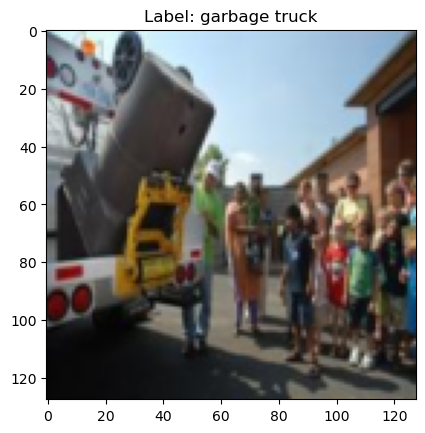

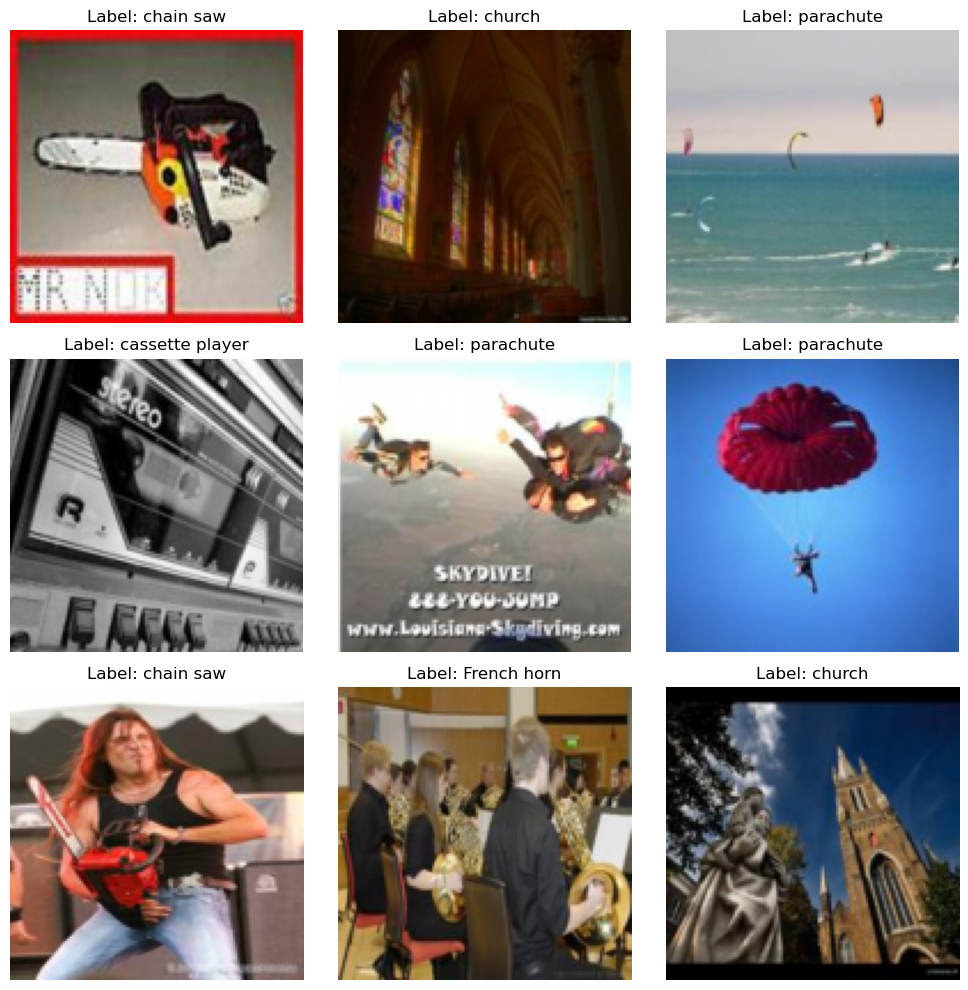

In [ ]:
#| notest

dm = ImageDataModule(
    'frgfm/imagenette','160px',
    transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((128, 128))]),
    data_dir='../data/image',
    train_val_split=[0.8, 0.2],
    batch_size = 16,
    num_workers = 0, # main process
    pin_memory= False,
    persistent_workers=False,
    exclude_grey_scale = True
)

# download or reference data from dir
dm.prepare_data()

# define train, eval, test subsets
dm.setup()
print(f" num_classes: {dm.num_classes}, labels: {dm.label_names}, img shape: {dm.train_ds[0][0].shape}")
# show data
dm.show(1)
dm.show_grid(3,3)

"batch_size":         32
"data_dir":           ../data/image
"exclude_grey_scale": True
"name":               frgfm/imagenette
"num_workers":        0
"persistent_workers": False
"pin_memory":         False
"train_val_split":    [0.8, 0.2]
"transforms":         Compose(
      ToTensor()
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True)
)


/var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_78438/575801441.py:163: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


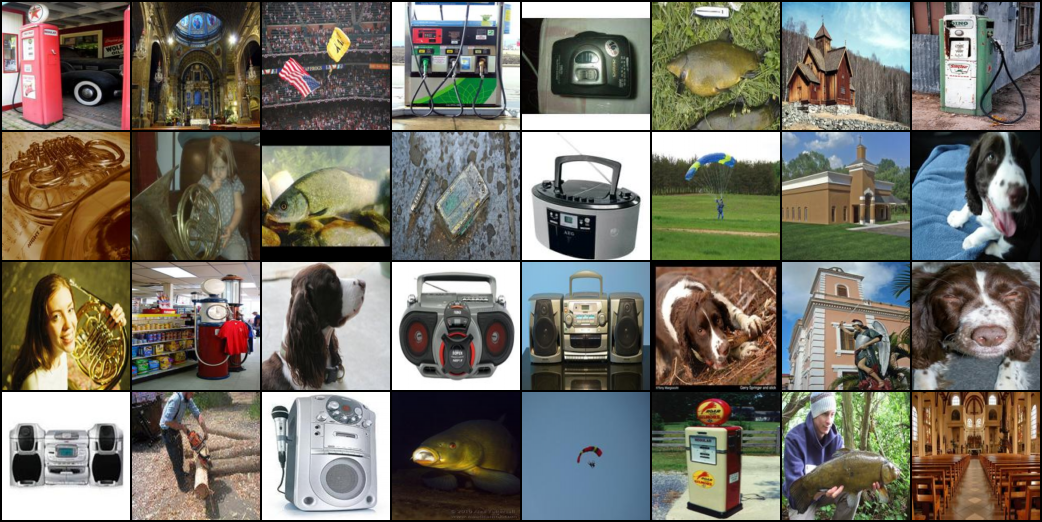

In [ ]:
#| notest

dm.hparams.batch_size = 32
print(dm.hparams)

xb, yb = next(iter(dm.train_dataloader()))
# print(xb.shape)
dm.show_batch(xb)

In [ ]:
# dm.label_names

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

In [ ]:
#| notest
# access data batches via dataloader
test_dl = dm.test_dataloader()
# X,Y = next(iter(test_dl))
# print("X dim(B,C,W,H): ", X.shape, "Y: dim(B)", Y.shape)


### Config

[17:28:55] INFO - Init ImageDataModule for fashion_mnist
[17:29:08] INFO - split train into train/val [0.8, 0.2]
[17:29:08] INFO - train: 48000 val: 12000, test: 10000


num_classes: 10, batch_size: 128
labels: ['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X: torch.Size([1, 32, 32]), Y: 9


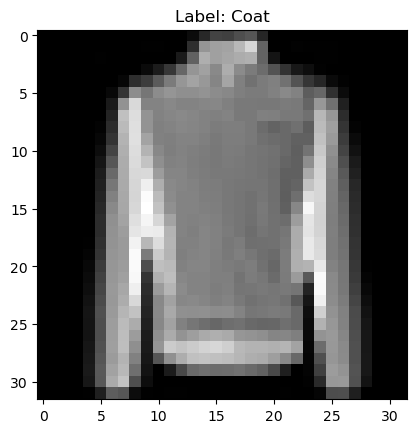

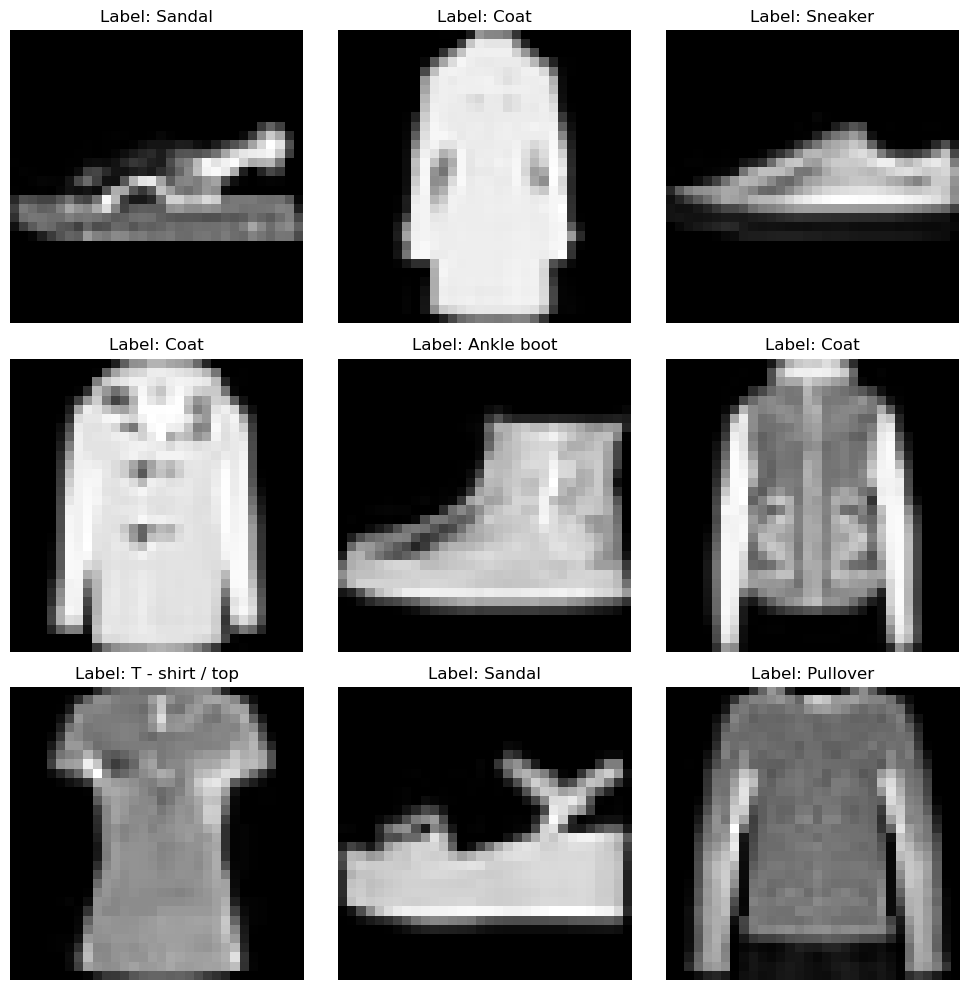

In [ ]:
#| notest

# cfg = OmegaConf.load("../config/image/data/mnist.yaml")
# print(cfg.datamodule)
# dm = instantiate(cfg.datamodule)
# dm.prepare_data()
# dm.setup()
# test_dl = dm.test_dataloader()
# len(dm.test_ds), len(dm.train_ds), len(dm.val_ds)
cfg = OmegaConf.load('../config/data/image/fashion_mnist.yaml')
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")
dm.show(1)
dm.show_grid(3,3)

[17:40:22] INFO - Init ImageDataModule for huggan/smithsonian_butterflies_subset
Repo card metadata block was not found. Setting CardData to empty.
[17:40:22] WARNING - Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
[17:40:24] WARNING - Repo card metadata block was not found. Setting CardData to empty.
[17:40:29] WARNING - split train into train/val/test [0.8, 0.2] 
[17:40:29] INFO - train: 800 val: 200, test: 200
[17:40:29] INFO - split train into train/val [0.8, 0.2]
[17:40:29] WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8029231..1.0000005].


num_classes: 45, batch_size: 128
labels: ['Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae, Epipaschiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Geometridae, Larentiinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Nymphalinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Satyrinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Saturniidae, Saturniinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae, Limenitidinae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Papilionidae, Papilioninae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae, Dismorphiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Arctiidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Lycaenidae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Papilionidae, Parnassiinae', 'Animalia, Arthropoda, Insecta, Lepidoptera, Pyralidae', 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Pieridae',

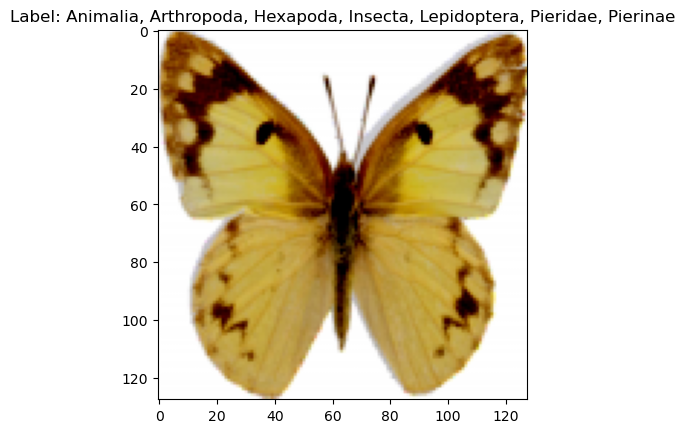

In [ ]:
#| notest
cfg = OmegaConf.load('../config/data/image/smithsonian_butterflies.yaml')
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()
print(f"num_classes: {dm.num_classes}, batch_size: {dm.batch_size}")
print(f"labels: {dm.label_names}")
x, y = dm.test_ds[0]
print(f"X: {x.shape}, Y: {y}")
x,y = next(iter(dm.train_dataloader()))
print(f"X: {x.shape}, Y: {y.shape}")
dm.show(1)

## Image Super Resolution Dataset

In [ ]:
#| export

TFM_LOW_RES = transforms.Compose(
    [
        transforms.Resize((32, 32), antialias=True), 
        # lambda x: F.interpolate(x.unsqueeze(0), scale_factor=(2,2), mode='bilinear').squeeze(0)
        # nn.Upsample(scale_factor=(2,2), mode='bilinear')
        transforms.Resize((64, 64), antialias=True),
    ]
)

class ImageSuperResDataset(ImageDataset):
    def __init__(
            self,
            name:str = 'fashion_mnist',
            data_dir:str = '../data/image',
            split='train',
            transform_x:Optional[transforms.Compose] = transforms.Compose([transforms.ToTensor(), TFM_LOW_RES]),
            transform_y:Optional[transforms.Compose] = transforms.Compose([transforms.ToTensor()])
    ):

        super().__init__(name=name, data_dir=data_dir, split=split)
        self.transform_x = transform_x
        self.transform_y = transform_y
    
    def __getitem__(self, idx:int) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        if self.transform_x:

            image_x = self.transform_x(self.images[idx])
        else:
            image_x = self.images[idx]

        if self.transform_y:
            image_y = self.transform_y(self.images[idx])
        else:
            image_y = self.images[idx]
        
        return image_x, image_y
        

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
#| notest
ds = ImageSuperResDataset(
    'slegroux/tiny-imagenet-200-clean',
    data_dir='../data/image',
    split='test'
    )

[16:45:34] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split test
[16:45:34] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split test
Overwrite dataset info from restored data version if exists.
[16:45:37] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[16:45:37] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects/nimrod/nbs/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
[16:45:37] INFO - Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects/nimrod/nbs/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
Loading Dat

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])

Text(0.5, 1.0, 'high res')

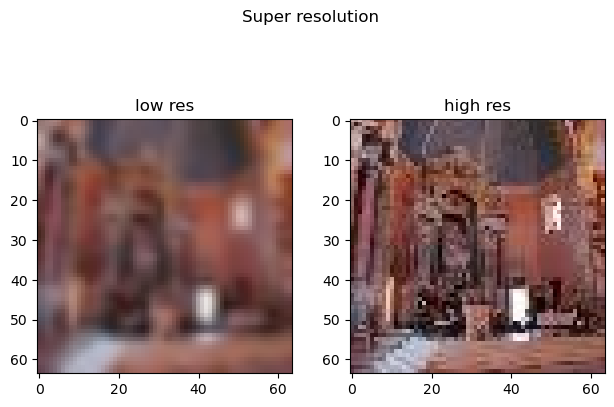

In [ ]:
#| notest
idx = torch.randint(0, len(ds), ())
x,y = ds[idx]
print(x.shape, y.shape)
fig, ax = plt.subplots(1,2)
fig.suptitle('Super resolution')
fig.tight_layout()
ax[0].imshow(x.permute(1,2,0).squeeze())
ax[0].set_title('low res')
ax[1].imshow(y.permute(1,2,0).squeeze())
ax[1].set_title('high res')



## Image SuperRes DataModule

In [ ]:
#| export

class ImageSuperResDataModule(ImageDataModule):
    def __init__(
        self,
        name:str = 'slegroux/tiny-imagenet-200-clean',
        data_dir:str = '../data/image',
        transform_x:Optional[transforms.Compose]=transforms.Compose([transforms.ToTensor(), TFM_LOW_RES]),
        transform_y:Optional[transforms.Compose]=transforms.Compose([transforms.ToTensor()]),
        train_val_split:Optional[List[float]] = [0.8, 0.2],
        batch_size:int = 64,
        num_workers:int = 0,
        pin_memory:bool = False,
        persistent_workers:bool = False
    ):
        logger.info(f"Init ImageSuperResDataModule for {name}")
        self.save_hyperparameters()

        super().__init__(
            name=name,
            data_dir=data_dir,
            train_val_split=train_val_split,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers
            )

        self.train_ds, self.test_ds, self.val_ds = None, None, None
        self._num_classes = None
        self.int2str = None

    def prepare_data(self) -> None:
        ds = partial(
            ImageSuperResDataset,
            name=self.hparams.name,
            data_dir=self.hparams.data_dir,
            transform_x=self.hparams.transform_x,
            transform_y=self.hparams.transform_y
            )
        self.train_ds = ds(split='train')
        self.test_ds = ds(split='test')
        self.val_ds = ds(split='validation')
    
    def show(self, idx:int):
        x, y = self.train_ds[idx]
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        fig.tight_layout()
        ax[0].imshow(x.permute(1,2,0).squeeze())
        ax[0].set_title('low res')
        ax[1].imshow(y.permute(1,2,0).squeeze())
        ax[1].set_title('high res')



In [ ]:
#| notest
# dm = ImageSuperResDataModule(
#     'slegroux/tiny-imagenet-200-clean',
#     data_dir='../data/image',
#     transform_x=transforms.Compose([transforms.ToTensor(), TFM_LOW_RES]),
#     transform_y=transforms.Compose([transforms.ToTensor()]),
# )
cfg = OmegaConf.load('../config/data/image/tiny_imagenet_superres.yaml')
dm = instantiate(cfg)
dm.prepare_data()
# dm.setup()

[16:51:36] INFO - Init ImageSuperResDataModule for slegroux/tiny-imagenet-200-clean
[16:51:36] INFO - Init ImageDataModule for slegroux/tiny-imagenet-200-clean
[16:51:39] INFO - loading dataset slegroux/tiny-imagenet-200-clean with args () from split train
[16:51:39] INFO - loading dataset slegroux/tiny-imagenet-200-clean from split train
Overwrite dataset info from restored data version if exists.
[16:51:42] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
[16:51:42] INFO - Loading Dataset info from ../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2
Found cached dataset tiny-imagenet-200-clean (/Users/slegroux/Projects/nimrod/nbs/../data/image/slegroux___tiny-imagenet-200-clean/default/0.0.0/4b908d89fab3eb36aa8ebcd41c1996b28da7d6f2)
[16:51:42] INFO - Found cached dataset tiny-imagenet-2

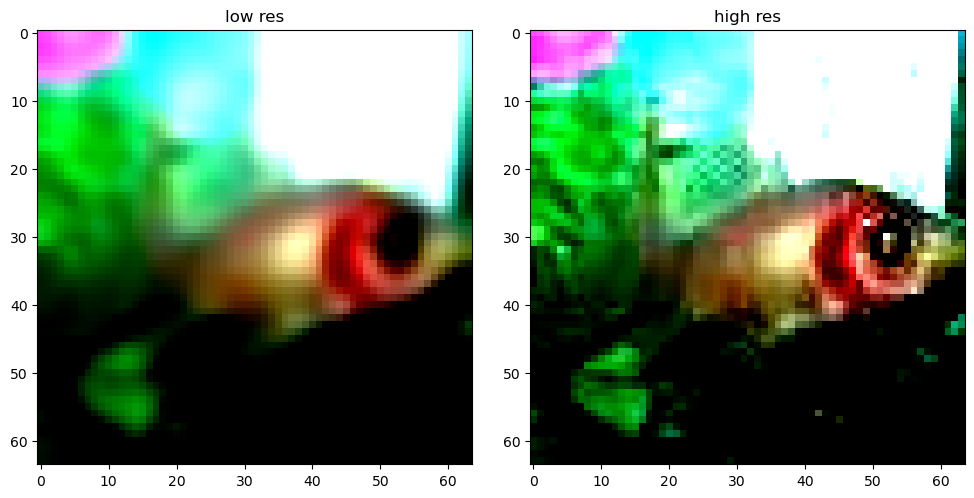

In [ ]:
#| notest
dm.show(0)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()